In [34]:
import serial
import threading
import sys
import pandas as pd 
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import requests
from io import StringIO

In [32]:
"""
STK500 implementation to bypass Arduino Bootloader
"""
STK_OK = 0x10
STK_INSYNC = 0x14
STK_GET_SYNC = 0x30
STK_LEAVE_PROGMODE = 0x51
CRC_EOP = 0x20

def STK500_arduino_connection(port, baudrate=9600):
    '''bypasses Arduino bootloader and makes Serial port connection'''
    print("Opening serial port")
    ser = serial.Serial(port,baudrate, timeout=2)
    print("Port Opened Successfully")
    
    print("resetting Arduino DTR ")
    ser.setDTR(False)
    time.sleep(0.1)
    ser.setDTR(True)
    time.sleep(0.1)
    ser.setDTR(False)
    print("DTR reset")
    
    print("Waiting for Bootloader...")
    time.sleep(1.5)
    print("Booloader active")
    
    print("Clearing serial buffers...")
    ser.reset_input_buffer()
    ser.reset_output_buffer()
    print("Buffers cleared")
    
    print("Attempting STK500 sync")
    sync_success = False
    
    for attempt in range(10):
        print(f"sync attempt {attempt+1}/10...")
        
        command = bytes([STK_GET_SYNC, CRC_EOP])
        ser.write(command)
        print(f"    SENT: {command.hex().upper()}")
        time.sleep(0.1)
        
        if ser.in_waiting >= 2:
            response = ser.read(2)
            print(f"    Received: {response.hex().upper()}")
            
            if response == bytes([STK_INSYNC, STK_OK]):
                Print("STK500 sync SUCCESS")
                sync_success = True
                break
            else:
                print(f"unexpected response: {response.hex()}")
        else:
            print("No response received")
        
        time.sleep(0.1)
        if not sync_success:
            print("STK500 sync failed")
            ser.close()
            return False
        
        print("Exiting programming mode...")
        command = bytes([STK_LEAVE_PROGMODE, CRC_EOP])
        ser.write(command)
        print(f"    Sent: {command.hex().upper()}")
        
        time.sleep(0.1)
        if ser.in_waiting >=2:
            response = ser.read(2)
            print(f"    Received: {response.hex().upper()}")
            
            if response == bytes([STK_INSYNC, STK_OK]):
                print("exited programming mode")
            else:
                print(f"unexpected response: {response.hex()}")
            time.sleep(0.5)
            
            if ser.in_waiting > 0:
                garbage = ser.read(ser.in_waiting)
                print("cleared remaining bootloader data")
            
            print("Arduino should now be running user program")
            
            return ser

In [42]:
STK500_arduino_connection('COM3', 9600)

Opening serial port
Port Opened Successfully
resetting Arduino DTR 
DTR reset
Waiting for Bootloader...
Booloader active
Clearing serial buffers...
Buffers cleared
Attempting STK500 sync
sync attempt 1/10...
    SENT: 3020
No response received
STK500 sync failed


False

In [24]:
#issues with bypassing bootloader on Arduino -- circle back

class ArduinoMonitor:
    def __init__(self, port='COM3', baud=9600):
        '''defines serial port connection'''
        self.ser = serial.Serial(port,baud)  #open port COM3
        ser.dtr = False
        self.data = [] #initiate array
        self.running = False #monitoring base condtion
        self.thread = None #threading?
        
    def start_monitoring(self):
        '''monitor wrapping function with paralell call to monitor loop'''
        self.running = True #turn boolean on
        self.thread = threading.Thread(target=self._monitor_loop) #internal ref call? -- always looking for port outputs
        self.thread.daemon = True #dies when nb shuts down? needed for management?
        self.thread.start() #turns on port monitor?
        print("Monitoring Started...")
    
    def stop_monitoring(self):
        '''spins down monitor loop and closes wrapper'''
        self.running = False #turn boolean off
        if self.thread:
            self.thread.join() #shuts down paralell process of the port monitor loop
        print("Monitoring Stopped.")
        
    def _monitor_loop(self):
        '''looped process inside monitoring casing returning formatted array populated with CSV data'''
        while self.running:
            if self.ser.in_waiting: #logical -- Serial condition waiting for output from port
                line = self.ser.readline().decode().strip() #bitwise operations?
                if ',' in line and line != "Microseconds,ADC,Voltage":
                    try:
                        parts = line.split(',')
                        timestamp = float(parts[0])
                        adc = int(parts[1])
                        voltage = float(parts[2])
                        self.data.append([timestamp, adc, voltage]) #parse acc to CSV format -- Parts is cool
                    except:
                        pass #skip bad lines
            time.sleep(0.001) #small delay
            
    def get_dataframe(self):
        '''formatted array to dataframe'''
        return pd.DataFrame(self.data, columns=['Microseconds', 'ADC', 'Voltage'])
    
    def trigger_capture(self):
        '''trigger data dump on serial port'''
        self.ser.write(b'p')
        
    def reset_arduino(self):
        '''trigger reset on serial port -- should propagate to arduino IDE'''
        self.ser.write(b'r')
        
        

In [25]:
monitor  = ArduinoMonitor('COM3', 9600)
print(monitor.get_dataframe)

SerialException: could not open port 'COM3': PermissionError(13, 'Access is denied.', None, 5)

In [39]:
## native Jupyter HTTP capabilities to access local port?
response = requests.get('http://192.168.5.41')

data = pd.read_csv(StringIO(response.text))
print(data)


     Microseconds  ADC  Voltage
0               3  102   0.0205
1              26  101   0.0203
2              50  140   0.0282
3              74  106   0.0214
4              97   99   0.0199
..            ...  ...      ...
995         23689   97   0.0195
996         23712   90   0.0181
997         23739  101   0.0203
998         23762   99   0.0199
999         23786   92   0.0185

[1000 rows x 3 columns]


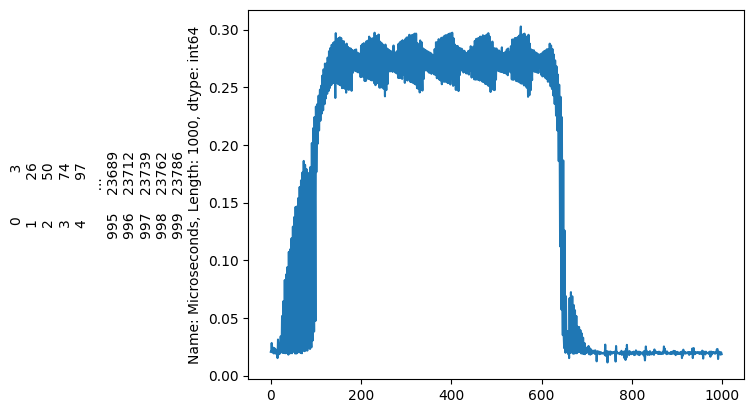

In [40]:
plt.plot(data['Voltage'])
plt.ylabel(data['Microseconds'])
plt.show()